# Analyzing upper/lower quartiles of SSIM distribution for Nipponbare - O.ruf comparison

In [5]:
#finding the Q1 and Q3 and ssim values in left and right tails
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/random_results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Oruf_chess_results_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()
final_df_filtered = final_df_filtered[(final_df_filtered['type'] == 'experiment')].copy()

# Calculate Q1 and Q3 for 'ssim'
q1 = final_df_filtered['ssim'].quantile(0.25)
q3 = final_df_filtered['ssim'].quantile(0.75)

print(f'Q1 (25th percentile): {q1:.2f}')
print(f'Q3 (75th percentile): {q3:.2f}')

# Split the DataFrame into left-tail and right-tail
left_tail_df = final_df_filtered[final_df_filtered['ssim'] < q1]
right_tail_df = final_df_filtered[final_df_filtered['ssim'] > q3]

# Save left-tail and right-tail DataFrames to separate files
left_tail_df.to_csv('NPB-Oruf_chess_results_25kb_left.tsv', sep='\t', index=False)
right_tail_df.to_csv('NPB-Oruf_chess_results_25kb_right.tsv', sep='\t', index=False)


Q1 (25th percentile): 0.27
Q3 (75th percentile): 0.61


/state/partition1/job-46813626/ipykernel_3260366/1273338069.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df_filtered = final_df_filtered[(final_df['type'] == 'experiment')].copy()
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


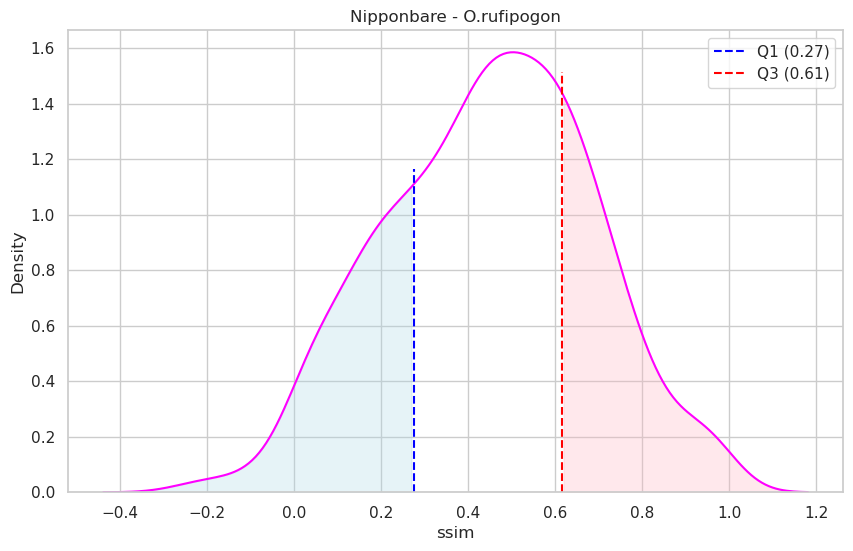

Total number of ssim values: 974
Number of rows with SN >= 0.5': 597
Mode of the density plot: 0.50


In [3]:
#kde plot of NPB-Oruf SSIM values with lower and upper tails shaded
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

results_folder_path = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/random_results_25'
result_files = glob.glob(f'{results_folder_path}/*.tsv')

df_list = []
for index, result_file in enumerate(result_files):
    file_type = 'experiment' if os.path.basename(result_file) == 'NPB-Oruf_chess_results_25kb.tsv' else f'random_{index}'
    df = pd.read_csv(result_file, sep='\t')
    df['type'] = file_type
    df_list.append(df)

final_df = pd.concat(df_list).reset_index(drop=True)

# Apply filters
final_df_filtered = final_df[(final_df['SN'] >= 0.5)].copy()
final_df_filtered = final_df_filtered[(final_df['type'] == 'experiment')].copy()

final_df_filtered['plot_order'] = final_df_filtered['type'].apply(lambda x: 0 if x == 'experiment' else 1)
final_df_filtered = final_df_filtered.sort_values(by='plot_order')

palette = {key: 'magenta' if key == 'experiment' else 'gray' for key in final_df_filtered['type'].unique()}

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Calculate Q1 and Q3
q1 = final_df_filtered['ssim'].quantile(0.25)
q3 = final_df_filtered['ssim'].quantile(0.75)

# Plot KDE 
plot = sns.kdeplot(data=final_df_filtered, x='ssim', hue='type', palette=palette, common_norm=False)

kde_x, kde_y = plot.get_lines()[0].get_data()

# Find the y-coordinate (ymax) corresponding to Q1 and Q3
ymax_q1 = np.interp(q1, kde_x, kde_y)
ymax_q3 = np.interp(q3, kde_x, kde_y)

# Plot the vertical lines (Q1 and Q3) only under the KDE plot and limit them from 0 to ymax
plt.axvline(x=q1, ymin=0, ymax=ymax_q1 / kde_y.max(), color='blue', linestyle='--', label=f'Q1 ({q1:.2f})')
plt.axvline(x=q3, ymin=0, ymax=ymax_q3 / kde_y.max(), color='red', linestyle='--', label=f'Q3 ({q3:.2f})')

# Shade left and right tail areas
left_tail = final_df_filtered[final_df_filtered['ssim'] < q1]
right_tail = final_df_filtered[final_df_filtered['ssim'] > q3]

kde_x, kde_y = plot.get_lines()[0].get_data()
plt.fill_between(kde_x, kde_y, where=(kde_x <= q1), alpha=0.3, color='lightblue')
plt.fill_between(kde_x, kde_y, where=(kde_x >= q3), alpha=0.3, color='lightpink')

handles, labels = plot.get_legend_handles_labels()

custom_handles = [plt.Line2D([0], [0], color='magenta'), plt.Line2D([0], [0], color='gray')]

plt.legend(handles, labels)

plt.xlabel('ssim')
plt.ylabel('Density')
plt.title('Nipponbare - O.rufipogon')

output_file_path = '/scratch/ak8725/figs/fig7E.pdf'
plt.savefig(output_file_path)

plt.show()

# Count rows with type 'experiment'
total = final_df[final_df['type'] == 'experiment'].shape[0]
print("Total number of ssim values:", total)
experiment_rows_count = final_df_filtered[final_df_filtered['type'] == 'experiment'].shape[0]
print("Number of rows with SN >= 0.5':", experiment_rows_count)

# Calculate mode of experiment
random_modes = []
experiment_mode = None

for key in final_df_filtered['type'].unique():
    subset = final_df_filtered[final_df_filtered['type'] == key]
    x_values = subset['ssim']
    
    # Remove infs and NaNs
    x_values = x_values.dropna()
    x_values = x_values[~np.isinf(x_values)]
    
    if len(x_values) == 0:
        print(f"No valid data for {key}")
        continue
    
    kde = stats.gaussian_kde(x_values)
    x_range = np.linspace(x_values.min(), x_values.max(), 1000)
    y_values = kde(x_range)
    mode_index = np.argmax(y_values)
    mode_value = x_range[mode_index]
    
    # Check if 'key' is a 'random_{index}' type
    if key.startswith('random_'):
        random_modes.append(mode_value)
    elif key == 'experiment':
        experiment_mode = mode_value
formatted_mode = f"{experiment_mode:.2f}"

# Print the mode for 'experiment'
print(f"Mode of the density plot: {formatted_mode}")

In [8]:
!wc -l NPB-Oruf_chess_results_25kb_left.tsv
!wc -l NPB-Oruf_chess_results_25kb_right.tsv

150 NPB-Oruf_chess_results_25kb_left.tsv
150 NPB-Oruf_chess_results_25kb_right.tsv


# Extracting windows with SSIM values in the tails

In [64]:
#creating .bed files with coordinates of NPB windows corresponding to windows from tail.tsv
# Define the file paths
bedpe_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf_pairs.bedpe'
tsv_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf_chess_results_25kb_right.tsv'
output_bed_file = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/right.bed'

# Create a set to store the ID numbers from mode2.tsv
tsv_ids = set()
with open(tsv_file, 'r') as tsv:
    next(tsv)  # Skip the header
    for line in tsv:
        parts = line.strip().split('\t')
        tsv_ids.add(int(parts[0]))

# Create the mode2.bed file
with open(output_bed_file, 'w') as output_bed:
    with open(bedpe_file, 'r') as bedpe:
        for line in bedpe:
            parts = line.strip().split('\t')
            bedpe_id = int(parts[6])
            if bedpe_id in tsv_ids:
                output_bed.write('\t'.join(parts[:3]) + '\n')

print(f'{output_bed_file} created successfully.')

/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/right.bed created successfully.


# Analyzing distribution of different features between tails of the ssim distribution

In [1]:
ls /scratch/ak8725/npb_feature_tracks/

SSD_genes.bed                      npb_line_per_500bp.bedgraph
WGD_genes.bed                      npb_rest_retro_te_per_500bp.bedgraph
npb_GC_content_per_500bp.bedgraph  npb_sine_per_500bp.bedgraph
npb_copia_per_500bp.bedgraph       npb_snp_per_500bp.bedgraph
npb_del_per_500bp.bedgraph         npb_sv_per_500bp.bedgraph
npb_dna_te_per_500bp.bedgraph      npb_te_per_500bp.bedgraph
npb_dup_per_500bp.bedgraph         omer_tips_del_per_500bp.bedgraph
npb_genes_per_500bp.bedgraph       omer_tips_ins_per_500bp.bedgraph
npb_gypsy_per_500bp.bedgraph       omer_tips_per_500bp.bedgraph
npb_ins_per_500bp.bedgraph         ssd_genes_per_500bp.bedgraph
npb_inv_per_500bp.bedgraph         wgd_genes_per_500bp.bedgraph


In [2]:
ls /scratch/ak8725/az_mrg/fitcons/from_zoe/

H3K18ac.bedgraph   H3K27me3.bw        PhastCons8wayChrAll.bedgraph*
H3K18ac.bw         H3K4me3.bedgraph   methylation_from_zoe.bedgraph*
H3K27ac.bedgraph   H3K4me3.bw         methylation_from_zoe.bw
H3K27ac.bw         PRO-seq.bedgraph*  rho.bedgraph
H3K27me3.bedgraph  PRO-seq.bw         rho.bw


In [24]:
#making file tab-delimited
!sed -i -e 's/\s/\t/g' /scratch/ak8725/npb_feature_tracks/npb_rest_retro_te_per_500bp.bedgraph

In [27]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'pro': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'meth': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'H3K18ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K18ac.bedgraph'),
    'H3K27ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27ac.bedgraph'),
    'H3K27me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27me3.bedgraph'),
    'H3K4me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K4me3.bedgraph'),
    'rho': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/rho.bedgraph'),
    'phast': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PhastCons8wayChrAll.bedgraph'),
    'genes': BedTool('/scratch/ak8725/npb_feature_tracks/npb_genes_per_500bp.bedgraph'),
    'gc': BedTool('/scratch/ak8725/npb_feature_tracks/npb_GC_content_per_500bp.bedgraph'),
    'sv': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sv_per_500bp.bedgraph'),
    'snp': BedTool('/scratch/ak8725/npb_feature_tracks/npb_snp_per_500bp.bedgraph'),
    'te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_te_per_500bp.bedgraph'),
    'dna_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_dna_te_per_500bp.bedgraph'),
    'gypsy': BedTool('/scratch/ak8725/npb_feature_tracks/npb_gypsy_per_500bp.bedgraph'),
    'copia': BedTool('/scratch/ak8725/npb_feature_tracks/npb_copia_per_500bp.bedgraph'),
    'line': BedTool('/scratch/ak8725/npb_feature_tracks/npb_line_per_500bp.bedgraph'),
    'sine': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sine_per_500bp.bedgraph'),
    'rest_retro_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_rest_retro_te_per_500bp.bedgraph'),
    'ssd': BedTool('/scratch/ak8725/npb_feature_tracks/ssd_genes_per_500bp.bedgraph'),
    'wgd': BedTool('/scratch/ak8725/npb_feature_tracks/wgd_genes_per_500bp.bedgraph'),
    'tips': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_per_500bp.bedgraph'),
    'tips_del': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_del_per_500bp.bedgraph'),
    'tips_ins': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_ins_per_500bp.bedgraph'),
    'exp': BedTool('/scratch/ak8725/expression/Nip_field2017_Normal.bed')
}

right = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right_filtered.bedpe')
left = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left_filtered.bedpe')

right = right.cut(range(3))
left = left.cut(range(3))

# Define the list of output file names
output_files = [
    'right.txt',
    'left.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "right" in output_name:
            result = right.map(obj, c=4, o='mean', output=output_name)
        elif "left" in output_name:
            result = left.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean pro per window calculated, output saved as pro_right.txt
Mean pro per window calculated, output saved as pro_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean meth per window calculated, output saved as meth_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean meth per window calculated, output saved as meth_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K18ac per window calculated, output saved as H3K18ac_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean H3K18ac per window calculated, output saved as H3K18ac_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K27ac per window calculated, output saved as H3K27ac_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean H3K27ac per window calculated, output saved as H3K27ac_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K27me3 per window calculated, output saved as H3K27me3_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean H3K27me3 per window calculated, output saved as H3K27me3_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K4me3 per window calculated, output saved as H3K4me3_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean H3K4me3 per window calculated, output saved as H3K4me3_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean rho per window calculated, output saved as rho_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean rho per window calculated, output saved as rho_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean phast per window calculated, output saved as phast_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean phast per window calculated, output saved as phast_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean genes per window calculated, output saved as genes_right.txt
Mean genes per window calculated, output saved as genes_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean gc per window calculated, output saved as gc_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean gc per window calculated, output saved as gc_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean sv per window calculated, output saved as sv_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean sv per window calculated, output saved as sv_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean snp per window calculated, output saved as snp_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean snp per window calculated, output saved as snp_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean te per window calculated, output saved as te_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean te per window calculated, output saved as te_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean dna_te per window calculated, output saved as dna_te_right.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean dna_te per window calculated, output saved as dna_te_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean gypsy per window calculated, output saved as gypsy_right.txt
Mean gypsy per window calculated, output saved as gypsy_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean copia per window calculated, output saved as copia_right.txt
Mean copia per window calculated, output saved as copia_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean line per window calculated, output saved as line_right.txt
Mean line per window calculated, output saved as line_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean sine per window calculated, output saved as sine_right.txt
Mean sine per window calculated, output saved as sine_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean rest_retro_te per window calculated, output saved as rest_retro_te_right.txt
Mean rest_retro_te per window calculated, output saved as rest_retro_te_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean ssd per window calculated, output saved as ssd_right.txt
Mean ssd per window calculated, output saved as ssd_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean wgd per window calculated, output saved as wgd_right.txt
Mean wgd per window calculated, output saved as wgd_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean tips per window calculated, output saved as tips_right.txt
Mean tips per window calculated, output saved as tips_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean tips_del per window calculated, output saved as tips_del_right.txt
Mean tips_del per window calculated, output saved as tips_del_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



Mean tips_ins per window calculated, output saved as tips_ins_right.txt
Mean tips_ins per window calculated, output saved as tips_ins_left.txt
Mean exp per window calculated, output saved as exp_right.txt
Mean exp per window calculated, output saved as exp_left.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.pclzvnb8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.62ger37b.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



In [29]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    right_file = f'{key}_right.txt'
    left_file = f'{key}_left.txt'
    
    # Load data from right and left files
    right_data = pd.read_csv(right_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    left_data = pd.read_csv(left_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Filter out rows where 'value' is not numeric
    right_data = right_data[right_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    left_data = left_data[left_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    
    # Perform the Mann-Whitney U test for mode1 and mode2
    u_statistic, p_value = stats.mannwhitneyu(right_data['value'].astype(float), left_data['value'].astype(float), alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for pro: 0.7014108384517905
P-value for meth: 0.2612064644456744
P-value for H3K18ac: 0.9209855471033004
P-value for H3K27ac: 0.7342006710565029
P-value for H3K27me3: 0.38857172316855604
P-value for H3K4me3: 0.7529553022731329
P-value for rho: 0.02742834162851501
P-value for phast: 0.05689945776841243
P-value for genes: 0.03132105269040897
P-value for gc: 0.39192283274035566
P-value for sv: 0.46093632767705495
P-value for snp: 0.0010227524565891584
P-value for te: 0.002596077520961793
P-value for dna_te: 0.5499125187123076
P-value for gypsy: 0.0038375951636384575
P-value for copia: 0.35818700580395757
P-value for line: 0.5593169672733989
P-value for sine: 0.23656349229603013
P-value for rest_retro_te: 0.5112636745671607
P-value for ssd: 0.18365576084436297
P-value for wgd: 0.004550673903183844
P-value for tips: 0.21406285013075188
P-value for tips_del: 0.21981577811872421
P-value for tips_ins: 0.266428582970169
P-value for exp: 0.32216631074763624


In [51]:
#compare the similarity scores between right and left

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/')

import pandas as pd
from scipy import stats

# Load the data from similarity_mode1.txt and similarity_mode2.txt into DataFrames
left_data = pd.read_csv('./left/similarity_left.txt', sep='\t', header=None, names=['seq1', 'value'])
right_data = pd.read_csv('./right/similarity_right.txt', sep='\t', header=None, names=['seq1', 'value'])

# Extract the values from the 'value' column of each group
group1_values = left_data['value']
group2_values = right_data['value']

# Perform the Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(group1_values, group2_values, alternative='two-sided')

# Print the results
print(f'P-value for sequence similarity: {p_value}')

P-value for sequence similarity: 1.5432681609952489e-19


In [35]:
%%capture
!pip install seaborn

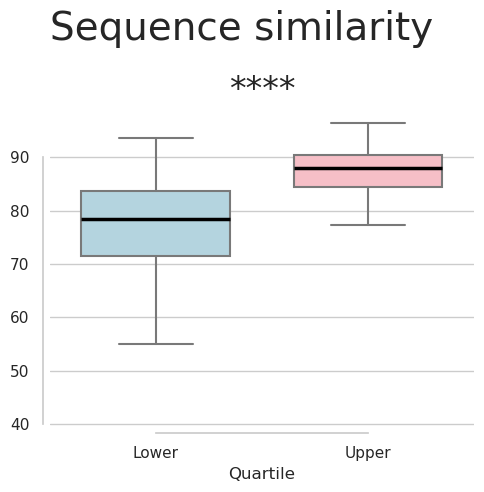

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Change working directory
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/')

# Load data from files into DataFrames
right_data = pd.read_csv('similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Convert 'col4' to numeric, handling errors with 'coerce' to replace non-numeric values with NaN
right_data['col4'] = pd.to_numeric(right_data['col4'], errors='coerce')
left_data['col4'] = pd.to_numeric(left_data['col4'], errors='coerce')

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
fig, ax = plt.subplots(figsize=(5, 5))

# Define custom colors for the box plots and points
boxplot_colors = ['lightblue', 'lightpink']
point_colors = 'black'

# Create box plots with custom colors
b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.7, fliersize=0,
                palette=boxplot_colors, medianprops=dict(color='black', linewidth=2.5))

p_value = 1.5432681609952489e-19

# Add significance stars based on the p-value
if p_value < 0.0001:
    significance = '****'
elif p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'ns'

# Customize the plot
plt.xlabel('Quartile')
plt.ylabel('')
sns.despine(offset=5, trim=True)

# Add the main title
fig.suptitle('Sequence similarity', fontsize=28)  # Adjust 'y' as needed for spacing

# Add the significance title
ax.set_title(f"{significance}", fontsize=24)

# Manually add labels to box plots
plt.tight_layout()
plt.savefig('/scratch/ak8725/figs/fig7F-1.pdf')
plt.savefig('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/fig7F-1.png')
plt.show()

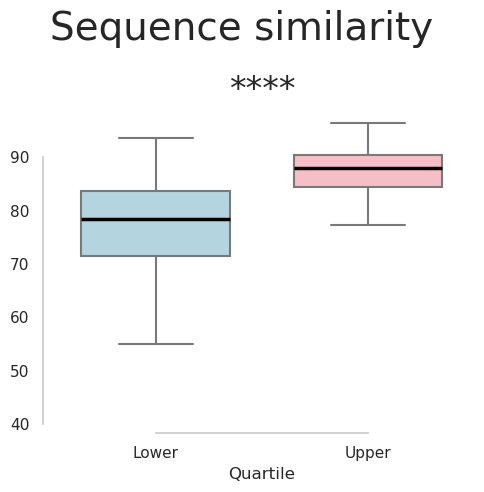

In [12]:
#plotting ss

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
fig, ax = plt.subplots(figsize=(5, 5))

# Define custom colors for the box plots and points
boxplot_colors = ['lightblue', 'lightpink']
point_colors = 'black'

# Create box plots with custom colors
b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.7, fliersize=0,
                palette=boxplot_colors, medianprops=dict(color='black', linewidth=2.5))

p_value = 1.54e-19

# Add significance stars based on the p-value
if p_value < 0.0001:
    significance = '****'
elif p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'ns'

# Customize the plot
plt.xlabel('Quartile')
plt.ylabel('')
sns.despine(offset=5, trim=True)
# Remove gridlines
ax.grid(False)

# Add the main title
fig.suptitle('Sequence similarity', fontsize=28)  # Adjust 'y' as needed for spacing

# Add the significance title
ax.set_title(f"{significance}", fontsize=24)

# Manually add labels to box plots
plt.tight_layout()
plt.savefig('/scratch/ak8725/figs/fig7F-1.pdf')
plt.show()

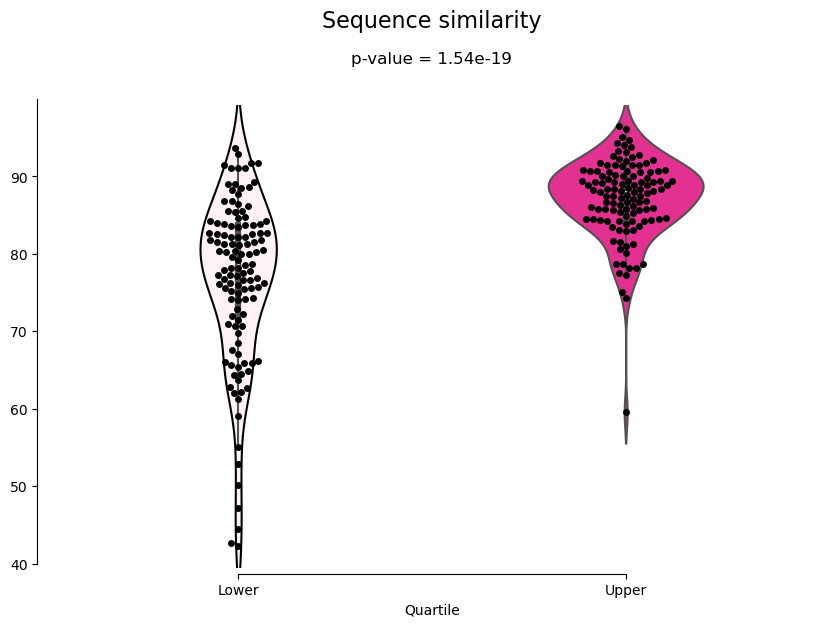

In [4]:
#optional: violinplot of ss

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('./right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('./left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the violin plots
violinplot_colors = ['lavenderblush', 'deeppink']

# Create a violin plot with custom colors
v = sns.violinplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4,
                   palette=violinplot_colors)

sns.despine(offset = 5, trim = True)
sns.swarmplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', color='black', size=5)

# Remove the fliers (outliers)
v = v.get_figure()
v.gca().collections[0].set_edgecolor('black')

plt.xlabel('Quartile')
plt.ylabel('')

plt.title("Sequence similarity", fontsize=16, y=1.15)  # Larger font size
plt.text(0.5, 1.1, "p-value = 1.54e-19", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)  # Centered p-value

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/oruf_tails.png'

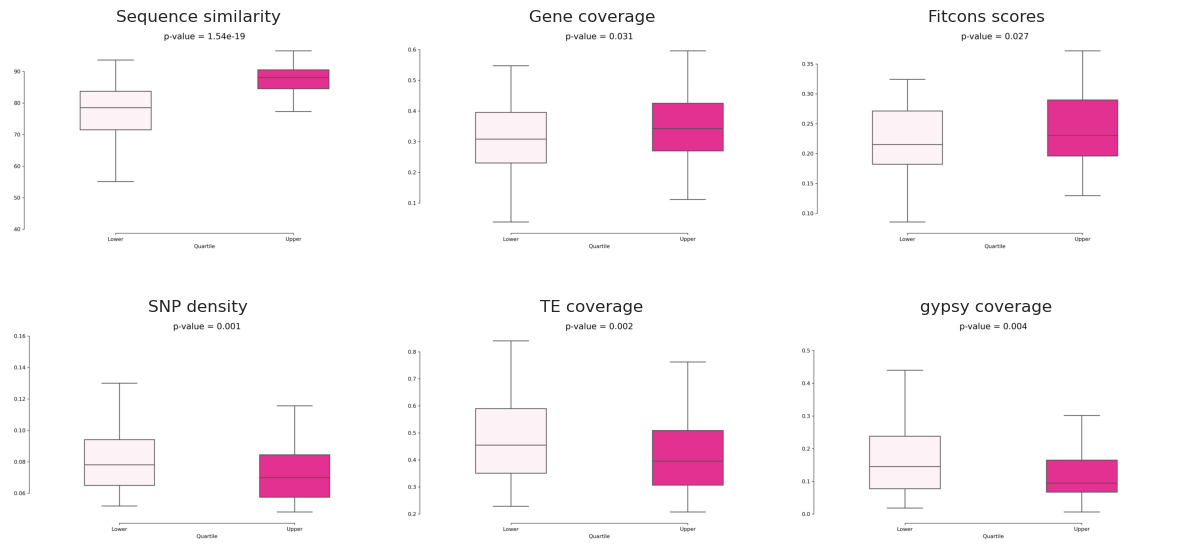

In [7]:
import os
import matplotlib.pyplot as plt
import math

# Directory containing your .png files
png_dir = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions_NPB_ref/NPB-Oruf/'

# Define the order and titles for each image
image_order = [
    {'filename': 'rho.png', 'title': 'Fitcons scores'},
    {'filename': 'ss.png', 'title': 'Sequence similarity'},
    {'filename': 'genes.png', 'title': 'Gene coverage'},
    {'filename': 'snp.png', 'title': 'SNP density'},
    {'filename': 'te.png', 'title': 'TE coverage'},
    {'filename': 'gypsy.png', 'title': 'gypsy coverage'},
]

# Create a dictionary to map filenames to image_info dictionaries
image_info_dict = {entry['filename']: entry for entry in image_order}

# List of filenames sorted in the desired order
sorted_filenames = [
    'ss.png', 'genes.png', 'rho.png', 'snp.png',  'te.png', 'gypsy.png'
]

# Calculate the number of rows and columns in the grid based on the number of images
num_images = len(sorted_filenames)
num_cols = 3
num_rows = math.ceil(num_images / num_cols)

# Specify the height ratio for subplots (reduce the height ratio for tighter rows)
height_ratios = [1, 0.6]  # Adjust as needed

# Calculate the figsize based on the height ratios and number of columns
fig_width = 12
fig_height = fig_width * (sum(height_ratios) / num_cols)

# Create a new figure for the combined image with adjusted height ratio
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios': height_ratios})

# Iterate through the list of filenames and plot images in the specified order
for i, filename in enumerate(sorted_filenames):
    row = i // num_cols
    col = i % num_cols
    img = plt.imread(os.path.join(png_dir, filename))
    
    # Plot the image on the corresponding subplot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels and ticks
    
    # Add an asterisk to the title if the filename is in filenames_with_asterisk
    image_info = image_info_dict.get(filename, {})
    title = image_info.get("title", "")
    
    # Add the title with the optional asterisk
    axes[row, col].set_title(title)

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined image
output_filename = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/oruf_tails.png'
plt.savefig(output_filename, dpi=300)

# Show the combined image (optional)
plt.show()

## Comparing NPB TAD coverage

In [1]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'tads': BedTool('/scratch/ak8725/npb_feature_tracks/tads_per_500bp.bedgraph'),
}

right = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right_filtered.bedpe')
left = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left_filtered.bedpe')

right = right.cut(range(3))
left = left.cut(range(3))

# Define the list of output file names
output_files = [
    'right.txt',
    'left.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "right" in output_name:
            result = right.map(obj, c=4, o='mean', output=output_name)
        elif "left" in output_name:
            result = left.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

Mean tads per window calculated, output saved as tads_right.txt
Mean tads per window calculated, output saved as tads_left.txt


***** WARNING: File /state/partition1/job-38913427/pybedtools.rzm0qh0c.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38913427/pybedtools.rzm0qh0c.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38913427/pybedtools.1zivergj.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-38913427/pybedtools.1zivergj.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



In [2]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    right_file = f'{key}_right.txt'
    left_file = f'{key}_left.txt'
    
    # Load data from right and left files
    right_data = pd.read_csv(right_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    left_data = pd.read_csv(left_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Filter out rows where 'value' is not numeric
    right_data = right_data[right_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    left_data = left_data[left_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    
    # Perform the Mann-Whitney U test for mode1 and mode2
    u_statistic, p_value = stats.mannwhitneyu(right_data['value'].astype(float), left_data['value'].astype(float), alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for tads: 0.3190941674344816


# Comparing windows with similar ss values (80-90)
Chose ss values 80 - 90<br>
49 windows in each group

In [68]:
#identify range of ss where both left and right data can be found
import pandas as pd
import numpy as np

# Load the data
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Find the minimum and maximum values in each dataset
right_min = right_data['col4'].min()
right_max = right_data['col4'].max()
left_min = left_data['col4'].min()
left_max = left_data['col4'].max()

# Determine the overlapping range
overlap_range = (max(right_min, left_min), min(right_max, left_max))

# Find the number of values in each group that fall within the overlapping range
right_values_within_range = right_data[(right_data['col4'] >= overlap_range[0]) & (right_data['col4'] <= overlap_range[1])]
left_values_within_range = left_data[(left_data['col4'] >= overlap_range[0]) & (left_data['col4'] <= overlap_range[1])]

# Calculate the percentage of values in each group within the overlapping range
percentage_right_within_range = (len(right_values_within_range) / len(right_data)) * 100
percentage_left_within_range = (len(left_values_within_range) / len(left_data)) * 100

print("Overlap Range:", overlap_range)
print("Percentage of Right Values Within Range:", percentage_right_within_range, "%")
print("Percentage of Left Values Within Range:", percentage_left_within_range, "%")

Overlap Range: (59.5, 93.6)
Percentage of Right Values Within Range: 94.0677966101695 %
Percentage of Left Values Within Range: 93.38842975206612 %


In [85]:
# Load the data
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Determine the range to analyze
overlap_range = (80, 90)

# Find the number of values in each group that fall within the overlapping range
right_values_within_range = right_data[(right_data['col4'] >= overlap_range[0]) & (right_data['col4'] <= overlap_range[1])]
left_values_within_range = left_data[(left_data['col4'] >= overlap_range[0]) & (left_data['col4'] <= overlap_range[1])]

# Calculate the percentage of values in each group within the overlapping range
percentage_right_within_range = (len(right_values_within_range))
percentage_left_within_range = (len(left_values_within_range))

print("Analysis Range:", overlap_range)
print("Number of Right Values Within Range:", percentage_right_within_range)
print("Number of Left Values Within Range:", percentage_left_within_range)

Analysis Range: (80, 90)
Number of Right Values Within Range: 76
Number of Left Values Within Range: 49


In [ ]:
#creating left_8090.bedpe and right_8090.bedpe with 49 windows each, with ss within 80-90 range

In [2]:
import pandas as pd
import random

# Load the data
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Determine the range to analyze
overlap_range = (80, 90)

# Filter rows within the specified range
right_values_within_range = right_data[(right_data['col4'] >= overlap_range[0]) & (right_data['col4'] <= overlap_range[1])]
left_values_within_range = left_data[(left_data['col4'] >= overlap_range[0]) & (left_data['col4'] <= overlap_range[1])]

# Randomly select 49 rows from right_values_within_range (if there are more than 49)
if len(right_values_within_range) > 49:
    right_values_within_range = right_values_within_range.sample(n=49, random_state=42)

# Create new files with the selected rows
right_values_within_range.to_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/similarity_8090_right.txt', sep='\t', header=None, index=None)
left_values_within_range.to_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/similarity_8090_left.txt', sep='\t', header=None, index=None)

In [7]:
#create .bed files with 80-90 ss scored windows
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

# Read the contents of the similarity file into a dictionary
similarity_dict = {}
with open('similarity_8090_left.txt', 'r') as similarity_file:
    for line in similarity_file:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            seq_num = int(parts[0].replace('seq', ''))
            similarity_dict[seq_num] = parts[1]

# Create a new file for the filtered results
with open('left_filtered.bedpe', 'r') as input_file, open('lef_8090.bed', 'w') as output_file:
    for i, line in enumerate(input_file, 1):
        seq_num = i  # Generate an ordinary number for this row (1-based)
        if seq_num in similarity_dict:
            # Split the line into columns
            columns = line.strip().split('\t')
            if len(columns) >= 3:  # Ensure there are at least 3 columns
                # Write only the first three columns to the output file
                output_file.write('\t'.join(columns[:3]) + '\n')

print("Filtered data saved to 'right_8090.bed'")

Filtered data saved to 'right_8090.bed'


In [2]:
import os 
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'pro': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'meth': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'H3K18ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K18ac.bedgraph'),
    'H3K27ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27ac.bedgraph'),
    'H3K27me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27me3.bedgraph'),
    'H3K4me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K4me3.bedgraph'),
    'rho': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/rho.bedgraph'),
    'phast': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PhastCons8wayChrAll.bedgraph'),
    'genes': BedTool('/scratch/ak8725/npb_feature_tracks/npb_genes_per_500bp.bedgraph'),
    'gc': BedTool('/scratch/ak8725/npb_feature_tracks/npb_GC_content_per_500bp.bedgraph'),
    'sv': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sv_per_500bp.bedgraph'),
    'snp': BedTool('/scratch/ak8725/npb_feature_tracks/npb_snp_per_500bp.bedgraph'),
    'te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_te_per_500bp.bedgraph'),
    'dna_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_dna_te_per_500bp.bedgraph'),
    'gypsy': BedTool('/scratch/ak8725/npb_feature_tracks/npb_gypsy_per_500bp.bedgraph'),
    'copia': BedTool('/scratch/ak8725/npb_feature_tracks/npb_copia_per_500bp.bedgraph'),
    'line': BedTool('/scratch/ak8725/npb_feature_tracks/npb_line_per_500bp.bedgraph'),
    'sine': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sine_per_500bp.bedgraph'),
    'rest_retro_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_rest_retro_te_per_500bp.bedgraph'),
    'ssd': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'wgd': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'tips': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_per_500bp.bedgraph'),
    'tips_del': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_del_per_500bp.bedgraph'),
    'tips_ins': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_ins_per_500bp.bedgraph'),
    'exp': BedTool('/scratch/ak8725/expression/Nip_field2017_Normal.bed')
}

right = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right_8090.bed')
left = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left_8090.bed')

right = right.cut(range(3))
left = left.cut(range(3))

# Define the list of output file names
output_files = [
    'right8090.txt',
    'left8090.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "right" in output_name:
            result = right.map(obj, c=4, o='mean', output=output_name)
        elif "left" in output_name:
            result = left.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean pro per window calculated, output saved as pro_right8090.txt
Mean pro per window calculated, output saved as pro_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean meth per window calculated, output saved as meth_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean meth per window calculated, output saved as meth_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean H3K18ac per window calculated, output saved as H3K18ac_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K18ac per window calculated, output saved as H3K18ac_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean H3K27ac per window calculated, output saved as H3K27ac_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K27ac per window calculated, output saved as H3K27ac_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean H3K27me3 per window calculated, output saved as H3K27me3_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K27me3 per window calculated, output saved as H3K27me3_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean H3K4me3 per window calculated, output saved as H3K4me3_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean H3K4me3 per window calculated, output saved as H3K4me3_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean rho per window calculated, output saved as rho_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean rho per window calculated, output saved as rho_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean phast per window calculated, output saved as phast_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean phast per window calculated, output saved as phast_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean genes per window calculated, output saved as genes_right8090.txt
Mean genes per window calculated, output saved as genes_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean gc per window calculated, output saved as gc_right8090.txt
Mean gc per window calculated, output saved as gc_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean sv per window calculated, output saved as sv_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean sv per window calculated, output saved as sv_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean snp per window calculated, output saved as snp_right8090.txt
Mean snp per window calculated, output saved as snp_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean te per window calculated, output saved as te_right8090.txt
Mean te per window calculated, output saved as te_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean dna_te per window calculated, output saved as dna_te_right8090.txt
Mean dna_te per window calculated, output saved as dna_te_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean gypsy per window calculated, output saved as gypsy_right8090.txt
Mean gypsy per window calculated, output saved as gypsy_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean copia per window calculated, output saved as copia_right8090.txt
Mean copia per window calculated, output saved as copia_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean line per window calculated, output saved as line_right8090.txt
Mean line per window calculated, output saved as line_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean sine per window calculated, output saved as sine_right8090.txt
Mean sine per window calculated, output saved as sine_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean rest_retro_te per window calculated, output saved as rest_retro_te_right8090.txt
Mean rest_retro_te per window calculated, output saved as rest_retro_te_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean ssd per window calculated, output saved as ssd_right8090.txt
Mean ssd per window calculated, output saved as ssd_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000



Mean wgd per window calculated, output saved as wgd_right8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean wgd per window calculated, output saved as wgd_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean tips per window calculated, output saved as tips_right8090.txt
Mean tips per window calculated, output saved as tips_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean tips_del per window calculated, output saved as tips_del_right8090.txt
Mean tips_del per window calculated, output saved as tips_del_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



Mean tips_ins per window calculated, output saved as tips_ins_right8090.txt
Mean tips_ins per window calculated, output saved as tips_ins_left8090.txt
Mean exp per window calculated, output saved as exp_right8090.txt
Mean exp per window calculated, output saved as exp_left8090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.26hyk2sa.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.e58stxu3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



In [104]:
#calculating p-values for all features comparison between quartiles
#no significant differences, only rest reto te = 0.051

import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    right_file = f'{key}_right8090.txt'
    left_file = f'{key}_left8090.txt'
    
    # Load data from right and left files
    right_data = pd.read_csv(right_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    left_data = pd.read_csv(left_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Filter out rows where 'value' is not numeric
    right_data = right_data[right_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    left_data = left_data[left_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    
    # Perform the Mann-Whitney U test for mode1 and mode2
    u_statistic, p_value = stats.mannwhitneyu(right_data['value'].astype(float), left_data['value'].astype(float), alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for pro: 0.7437891454097343
P-value for meth: 0.3233367042855212
P-value for H3K18ac: 0.2216712511347756
P-value for H3K27ac: 0.19842802344858712
P-value for H3K27me3: 0.06166869188708032
P-value for H3K4me3: 0.11148199834144297
P-value for rho: 0.6289861739488809
P-value for phast: 0.634039398227619
P-value for genes: 0.4773810854064495
P-value for gc: 0.6039825047361085
P-value for sv: 0.937702915866323
P-value for snp: 0.688092030780744
P-value for te: 0.6595583232744953
P-value for dna_te: 0.3483020842633807
P-value for gypsy: 0.15121515510276254
P-value for copia: 0.7817008590474439
P-value for line: 0.842305069932857
P-value for sine: 0.24105266263877945
P-value for rest_retro_te: 0.05153902560064162
P-value for ssd: 0.7437891454097343
P-value for wgd: 0.3233367042855212
P-value for tips: 0.694090261708862
P-value for tips_del: 0.8200912285122762
P-value for tips_ins: 1.0


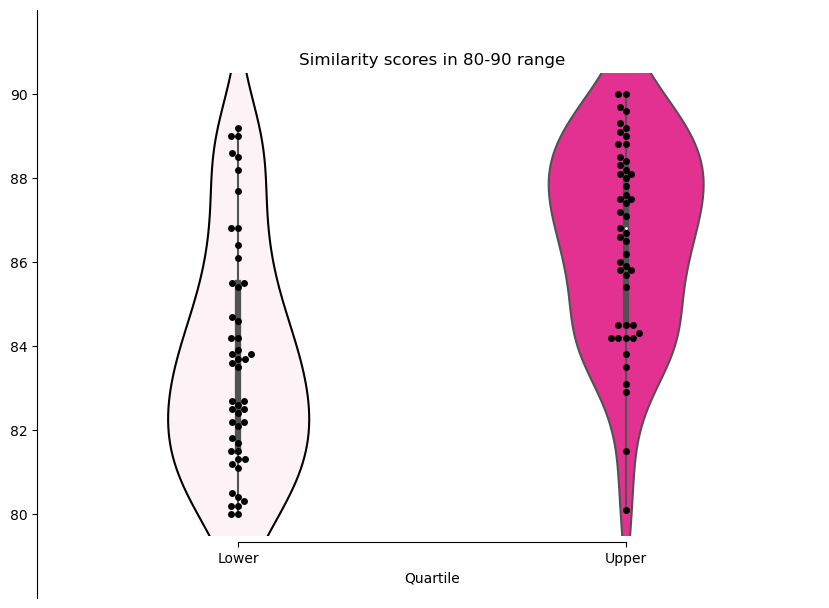

In [106]:
#ss in 80-90 range

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('./right/similarity_8090_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('./left/similarity_8090_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the violin plots
violinplot_colors = ['lavenderblush', 'deeppink']

# Create a violin plot with custom colors
v = sns.violinplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4,
                   palette=violinplot_colors)

sns.despine(offset = 5, trim = True)
#v.set_title("p-value = 1.54e-19", fontsize = 16)

# Set the point colors (if needed)
sns.swarmplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', color=point_colors, size=5)

# Remove the fliers (outliers)
v = v.get_figure()
v.gca().collections[0].set_edgecolor('black')

plt.xlabel('Quartile')
plt.ylabel('')
plt.title('Similarity scores in 80-90 range')

# Show the plot
plt.show()

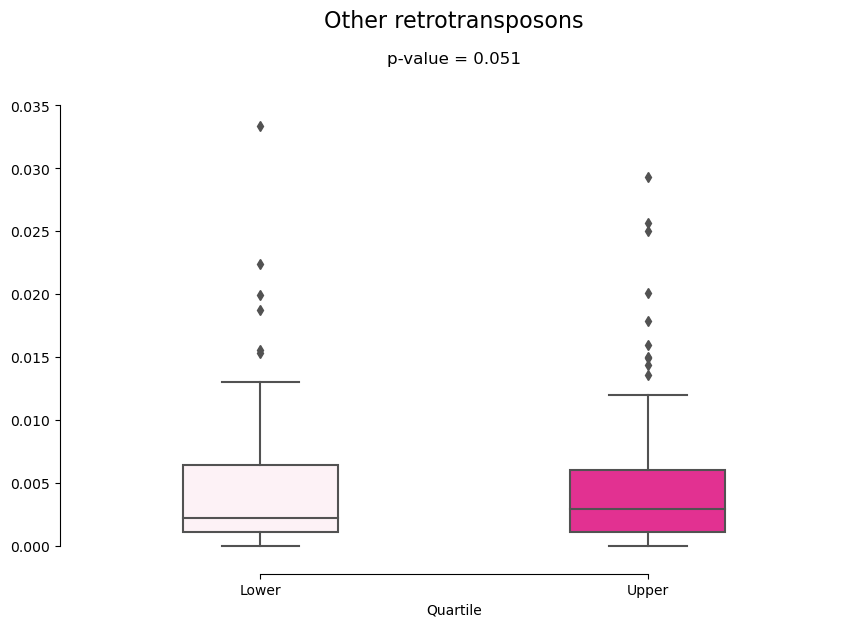

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('rest_retro_te_right7090.txt', sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])
left_data = pd.read_csv('rest_retro_te_left7090.txt', sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

# Convert 'col4' to numeric, handling non-numeric values as NaN
left_data['col4'] = pd.to_numeric(left_data['col4'], errors='coerce')
right_data['col4'] = pd.to_numeric(right_data['col4'], errors='coerce')

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the violin plots
boxplot_colors = ['lavenderblush', 'deeppink']

# Create a violin plot with custom colors
v = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4, 
                   palette=boxplot_colors)

sns.despine(offset=5, trim=True)

plt.xlabel('Quartile')
plt.ylabel('')

plt.title("Other retrotransposons", fontsize=16, y=1.15)  # Larger font size
plt.text(0.5, 1.1, "p-value = 0.051", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)  # Centered p-value

# Show the plot
plt.show()

# Gene expression differences between windows, ss=80-90

Using Nip_fileld data from 2017<br>
No significant differences

In [3]:
!head /scratch/ak8725/expression/Nip_field2017_Normal.bed

chr01	2349	10181	17.5
chr01	10584	11801	0
chr01	10738	11650	0
chr01	12087	15051	0
chr01	12174	13344	0
chr01	15765	19510	17.1666666666667
chr01	22207	26266	6
chr01	25235	25798	0
chr01	26517	28054	85.36
chr01	29234	33869	9.66666666666667


In [15]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'exp': BedTool('/scratch/ak8725/expression/Nip_field2017_Normal.bed'),
}

right = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right_8090.bed')
left = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left_8090.bed')

right = right.cut(range(3))
left = left.cut(range(3))

# Define the list of output file names
output_files = [
    'right7090.txt',
    'left7090.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "right" in output_name:
            result = right.map(obj, c=4, o='mean', output=output_name)
        elif "left" in output_name:
            result = left.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

Mean exp per window calculated, output saved as exp_right7090.txt
Mean exp per window calculated, output saved as exp_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.w6wlbkeh.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.w6wlbkeh.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1750000	2250000

***** WARNING: File /state/partition1/job-38704685/pybedtools.5qjgjvbs.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.5qjgjvbs.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	15500000	16000000



In [16]:
#calculating p-values

import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    right_file = f'{key}_right8090.txt'
    left_file = f'{key}_left8090.txt'
    
    # Load data from right and left files
    right_data = pd.read_csv(right_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    left_data = pd.read_csv(left_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Filter out rows where 'value' is not numeric
    right_data = right_data[right_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    left_data = left_data[left_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    
    # Perform the Mann-Whitney U test for mode1 and mode2
    u_statistic, p_value = stats.mannwhitneyu(right_data['value'].astype(float), left_data['value'].astype(float), alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for exp: 0.8201385851033123


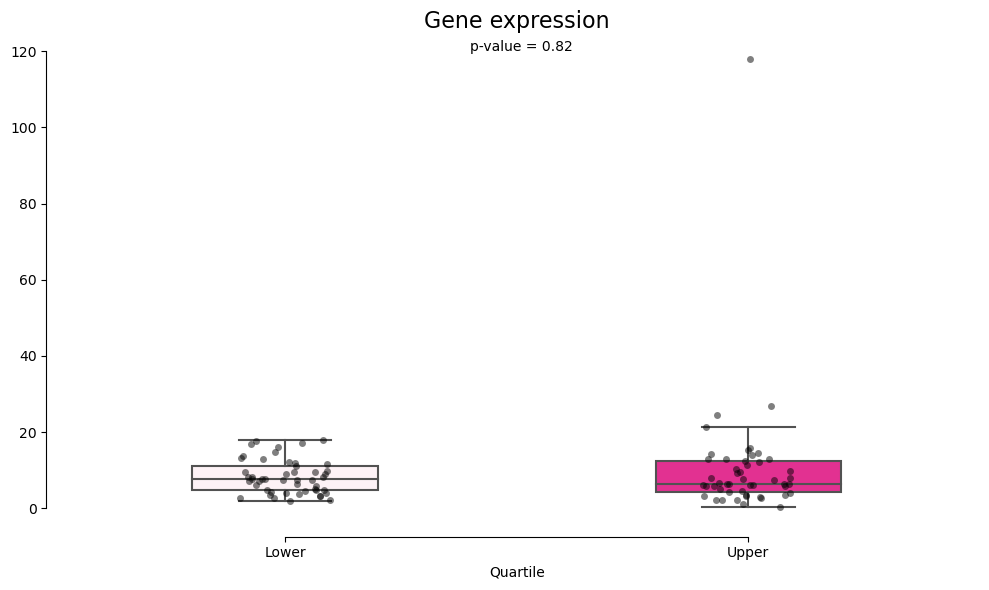

In [19]:
#plotting exp

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/exp_right8090.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/exp_left8090.txt', sep='\t', header=None, names=['chr', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the box plots and points
boxplot_colors = ['lavenderblush', 'deeppink']
point_colors = 'black'

# Create box plots with custom colors
b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4, fliersize=0,
            palette=boxplot_colors, showfliers=False)

#Overlay individual data points as black scatter plots
sns.stripplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', jitter=True,
              color=point_colors, alpha=0.5, size=5)

# Customize the plot
# plt.title('')
plt.xlabel('Quartile')
plt.ylabel('')

sns.despine(offset = 5, trim = True)
plt.title('Gene expression', fontsize = 16)
plt.text(0.4,120, "p-value = 0.82")

# Manually add labels to box plots
ax = plt.gca()

plt.tight_layout()
#plt.savefig('ss.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparing windows with similar ss values (70-90)
Chose ss values 70 - 90<br>
85/86 windows in each group

In [20]:
# Load the data
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Determine the range to analyze
overlap_range = (70, 90)

# Find the number of values in each group that fall within the overlapping range
right_values_within_range = right_data[(right_data['col4'] >= overlap_range[0]) & (right_data['col4'] <= overlap_range[1])]
left_values_within_range = left_data[(left_data['col4'] >= overlap_range[0]) & (left_data['col4'] <= overlap_range[1])]

# Calculate the percentage of values in each group within the overlapping range
percentage_right_within_range = (len(right_values_within_range))
percentage_left_within_range = (len(left_values_within_range))

print("Analysis Range:", overlap_range)
print("Number of Right Values Within Range:", percentage_right_within_range)
print("Number of Left Values Within Range:", percentage_left_within_range)

Analysis Range: (70, 90)
Number of Right Values Within Range: 85
Number of Left Values Within Range: 86


In [21]:
import pandas as pd
import random

# Load the data
right_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right/similarity_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left/similarity_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Determine the range to analyze
overlap_range = (70, 90)

# Filter rows within the specified range
right_values_within_range = right_data[(right_data['col4'] >= overlap_range[0]) & (right_data['col4'] <= overlap_range[1])]
left_values_within_range = left_data[(left_data['col4'] >= overlap_range[0]) & (left_data['col4'] <= overlap_range[1])]

# Randomly select 49 rows from right_values_within_range (if there are more than 49)
if len(right_values_within_range) > 49:
    right_values_within_range = right_values_within_range.sample(n=49, random_state=42)

# Create new files with the selected rows
right_values_within_range.to_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/similarity_7090_right.txt', sep='\t', header=None, index=None)
left_values_within_range.to_csv('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/similarity_7090_left.txt', sep='\t', header=None, index=None)

In [23]:
#create .bed files with 70-90 ss scored windows
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

# Read the contents of the similarity file into a dictionary
similarity_dict = {}
with open('similarity_7090_right.txt', 'r') as similarity_file:
    for line in similarity_file:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            seq_num = int(parts[0].replace('seq', ''))
            similarity_dict[seq_num] = parts[1]

# Create a new file for the filtered results
with open('right_filtered.bedpe', 'r') as input_file, open('left_7090.bed', 'w') as output_file:
    for i, line in enumerate(input_file, 1):
        seq_num = i  # Generate an ordinary number for this row (1-based)
        if seq_num in similarity_dict:
            # Split the line into columns
            columns = line.strip().split('\t')
            if len(columns) >= 3:  # Ensure there are at least 3 columns
                # Write only the first three columns to the output file
                output_file.write('\t'.join(columns[:3]) + '\n')

print("Filtered data saved")

Filtered data saved


In [25]:
import os 
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'pro': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'meth': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'H3K18ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K18ac.bedgraph'),
    'H3K27ac': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27ac.bedgraph'),
    'H3K27me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K27me3.bedgraph'),
    'H3K4me3': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/H3K4me3.bedgraph'),
    'rho': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/rho.bedgraph'),
    'phast': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PhastCons8wayChrAll.bedgraph'),
    'genes': BedTool('/scratch/ak8725/npb_feature_tracks/npb_genes_per_500bp.bedgraph'),
    'gc': BedTool('/scratch/ak8725/npb_feature_tracks/npb_GC_content_per_500bp.bedgraph'),
    'sv': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sv_per_500bp.bedgraph'),
    'snp': BedTool('/scratch/ak8725/npb_feature_tracks/npb_snp_per_500bp.bedgraph'),
    'te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_te_per_500bp.bedgraph'),
    'dna_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_dna_te_per_500bp.bedgraph'),
    'gypsy': BedTool('/scratch/ak8725/npb_feature_tracks/npb_gypsy_per_500bp.bedgraph'),
    'copia': BedTool('/scratch/ak8725/npb_feature_tracks/npb_copia_per_500bp.bedgraph'),
    'line': BedTool('/scratch/ak8725/npb_feature_tracks/npb_line_per_500bp.bedgraph'),
    'sine': BedTool('/scratch/ak8725/npb_feature_tracks/npb_sine_per_500bp.bedgraph'),
    'rest_retro_te': BedTool('/scratch/ak8725/npb_feature_tracks/npb_rest_retro_te_per_500bp.bedgraph'),
    'ssd': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'wgd': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/methylation_from_zoe.bedgraph'),
    'tips': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_per_500bp.bedgraph'),
    'tips_del': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_del_per_500bp.bedgraph'),
    'tips_ins': BedTool('/scratch/ak8725/npb_feature_tracks/omer_tips_ins_per_500bp.bedgraph'),
    'exp': BedTool('/scratch/ak8725/expression/Nip_field2017_Normal.bed')
}

right = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right_7090.bed')
left = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left_7090.bed')

right = right.cut(range(3))
left = left.cut(range(3))

# Define the list of output file names
output_files = [
    'right7090.txt',
    'left7090.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "right" in output_name:
            result = right.map(obj, c=4, o='mean', output=output_name)
        elif "left" in output_name:
            result = left.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean pro per window calculated, output saved as pro_right7090.txt
Mean pro per window calculated, output saved as pro_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean meth per window calculated, output saved as meth_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean meth per window calculated, output saved as meth_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K18ac per window calculated, output saved as H3K18ac_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean H3K18ac per window calculated, output saved as H3K18ac_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K27ac per window calculated, output saved as H3K27ac_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean H3K27ac per window calculated, output saved as H3K27ac_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K27me3 per window calculated, output saved as H3K27me3_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean H3K27me3 per window calculated, output saved as H3K27me3_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean H3K4me3 per window calculated, output saved as H3K4me3_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean H3K4me3 per window calculated, output saved as H3K4me3_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean rho per window calculated, output saved as rho_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean rho per window calculated, output saved as rho_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean phast per window calculated, output saved as phast_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean phast per window calculated, output saved as phast_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean genes per window calculated, output saved as genes_right7090.txt
Mean genes per window calculated, output saved as genes_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean gc per window calculated, output saved as gc_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean gc per window calculated, output saved as gc_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean sv per window calculated, output saved as sv_right7090.txt
Mean sv per window calculated, output saved as sv_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean snp per window calculated, output saved as snp_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean snp per window calculated, output saved as snp_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean te per window calculated, output saved as te_right7090.txt
Mean te per window calculated, output saved as te_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean dna_te per window calculated, output saved as dna_te_right7090.txt
Mean dna_te per window calculated, output saved as dna_te_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean gypsy per window calculated, output saved as gypsy_right7090.txt
Mean gypsy per window calculated, output saved as gypsy_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean copia per window calculated, output saved as copia_right7090.txt
Mean copia per window calculated, output saved as copia_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean line per window calculated, output saved as line_right7090.txt
Mean line per window calculated, output saved as line_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean sine per window calculated, output saved as sine_right7090.txt
Mean sine per window calculated, output saved as sine_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean rest_retro_te per window calculated, output saved as rest_retro_te_right7090.txt
Mean rest_retro_te per window calculated, output saved as rest_retro_te_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean ssd per window calculated, output saved as ssd_right7090.txt
Mean ssd per window calculated, output saved as ssd_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean wgd per window calculated, output saved as wgd_right7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean wgd per window calculated, output saved as wgd_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean tips per window calculated, output saved as tips_right7090.txt
Mean tips per window calculated, output saved as tips_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean tips_del per window calculated, output saved as tips_del_right7090.txt
Mean tips_del per window calculated, output saved as tips_del_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



Mean tips_ins per window calculated, output saved as tips_ins_right7090.txt
Mean tips_ins per window calculated, output saved as tips_ins_left7090.txt
Mean exp per window calculated, output saved as exp_right7090.txt
Mean exp per window calculated, output saved as exp_left7090.txt


***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.6w3ckex6.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000

***** WARNING: File /state/partition1/job-38704685/pybedtools.gn4c8ga1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	7250000	7750000



In [28]:
#calculating p-values for all features comparison between quartiles 70-90 range

import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    right_file = f'{key}_right7090.txt'
    left_file = f'{key}_left7090.txt'
    
    # Load data from right and left files
    right_data = pd.read_csv(right_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    left_data = pd.read_csv(left_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Filter out rows where 'value' is not numeric
    right_data = right_data[right_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    left_data = left_data[left_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    
    # Perform the Mann-Whitney U test for mode1 and mode2
    u_statistic, p_value = stats.mannwhitneyu(right_data['value'].astype(float), left_data['value'].astype(float), alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for pro: 0.7753502715968443
P-value for meth: 0.14445485899002894
P-value for H3K18ac: 0.3545725111082265
P-value for H3K27ac: 0.058630169171256546
P-value for H3K27me3: 0.005404001717680527
P-value for H3K4me3: 0.020205380244272767
P-value for rho: 0.799525752201065
P-value for phast: 0.6325230474821861
P-value for genes: 0.954387148946828
P-value for gc: 0.5026244264036054
P-value for sv: 0.5688833571162872
P-value for snp: 0.8404337985605543
P-value for te: 0.9945235161197556
P-value for dna_te: 0.9945235161197556
P-value for gypsy: 0.9671500846528995
P-value for copia: 0.4939164921863003
P-value for line: 0.8655547892980138
P-value for sine: 0.8243683132458199
P-value for rest_retro_te: 0.4379584077665416
P-value for ssd: 0.7753502715968443
P-value for wgd: 0.14445485899002894
P-value for tips: 0.5191960043821671
P-value for tips_del: 0.45701029637657353
P-value for tips_ins: 1.0
P-value for exp: 0.2724443988991626


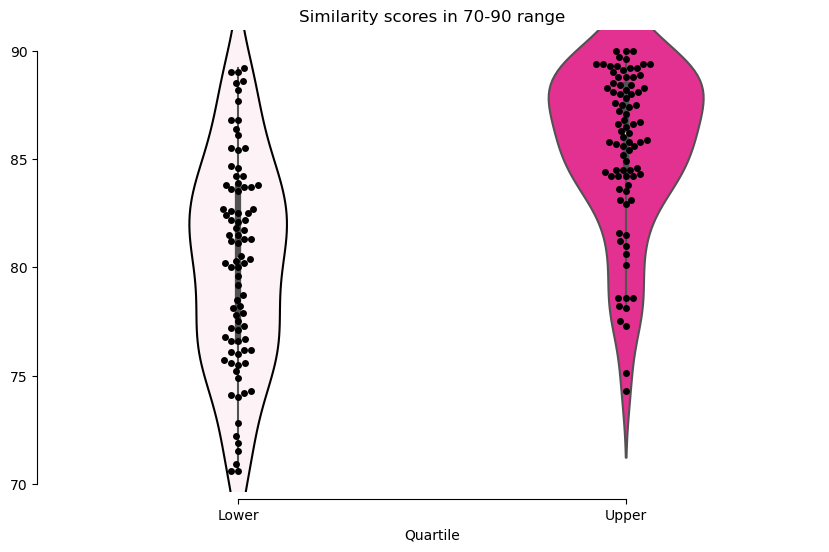

In [26]:
#ss in 70-90 range

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('./right/similarity_7090_right.txt', sep='\t', header=None, names=['chr', 'col4'])
left_data = pd.read_csv('./left/similarity_7090_left.txt', sep='\t', header=None, names=['chr', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the violin plots
violinplot_colors = ['lavenderblush', 'deeppink']

# Create a violin plot with custom colors
v = sns.violinplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4,
                   palette=violinplot_colors)

sns.despine(offset = 5, trim = True)
#v.set_title("p-value = 1.54e-19", fontsize = 16)

# Set the point colors (if needed)
sns.swarmplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', color=point_colors, size=5)

# Remove the fliers (outliers)
v = v.get_figure()
v.gca().collections[0].set_edgecolor('black')

plt.xlabel('Quartile')
plt.ylabel('')
plt.title('Similarity scores in 70-90 range')

# Show the plot
plt.show()

In [ ]:
#plotting significant only: H3K27ac (almost), H3K27me3, H3K4me3

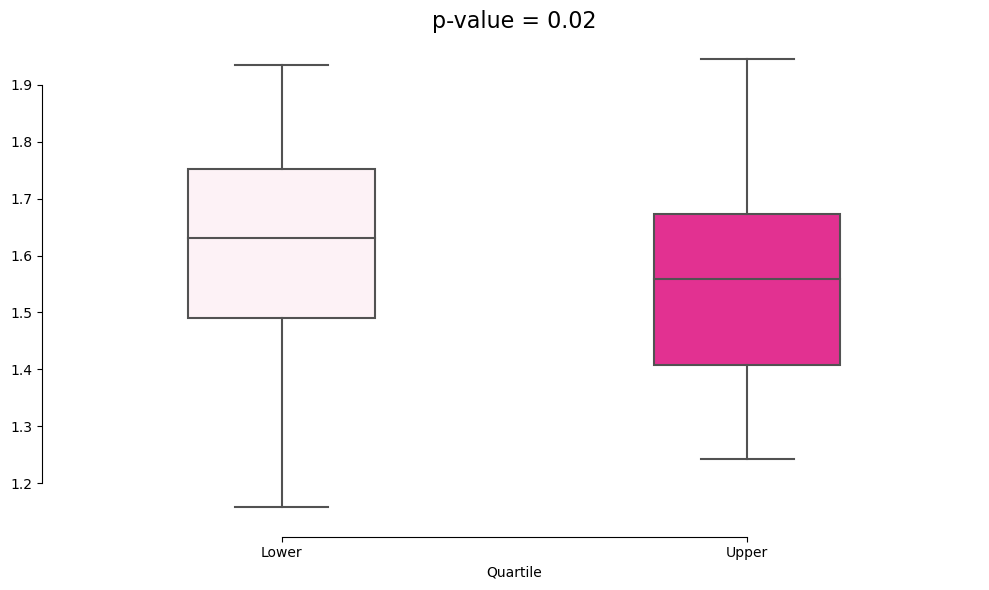

In [35]:
#I'm plotting figures with diff marks separately, as key.png
#then putting them all together into oruf_tails.png

import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('H3K4me3_right7090.txt', sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])
left_data = pd.read_csv('H3K4me3_left7090.txt', sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the box plots and points
boxplot_colors = ['lavenderblush', 'deeppink']
point_colors = 'black'

combined_data['col4'] = pd.to_numeric(combined_data['col4'], errors='coerce')

# Create box plots with custom colors
b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4, fliersize=0,
            palette=boxplot_colors)

# Customize the plot
# plt.title('')
plt.xlabel('Quartile')
plt.ylabel('')

sns.despine(offset = 5, trim = True)
b.set_title("p-value = 0.02", fontsize = 16)

# Manually add labels to box plots
ax = plt.gca()

plt.tight_layout()
plt.savefig('H3K4me3_7090.png', dpi=300, bbox_inches='tight')
plt.show()

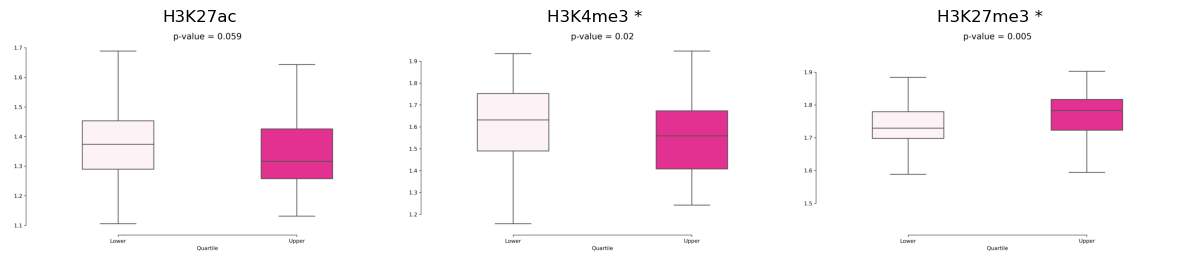

In [50]:
import os
import matplotlib.pyplot as plt
import math

# Directory containing your .png files
png_dir = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'

# Define the order and titles for each image
image_order = [
    {'filename': 'H3K4me3_7090.png', 'title': 'H3K4me3'},
    {'filename': 'H3K27ac_7090.png', 'title': 'H3K27ac'},
    {'filename': 'H3K27me3_7090.png', 'title': 'H3K27me3'}
]

# Specify the filenames where you want to add an asterisk
filenames_with_asterisk = ['H3K4me3_7090.png', 'H3K27me3_7090.png']

# Create a dictionary to map filenames to image_info dictionaries
image_info_dict = {entry['filename']: entry for entry in image_order}

# List of filenames sorted in the desired order
sorted_filenames = [
    'H3K27ac_7090.png', 'H3K4me3_7090.png', 'H3K27me3_7090.png'
]

# Calculate the number of rows and columns in the grid based on the number of images
num_images = len(sorted_filenames)
num_cols = 3
num_rows = math.ceil(num_images / num_cols)
    
# Create a new figure for the combined image with adjusted height ratio
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios': height_ratios})

# Flatten the axes array if it's 2D to handle both cases
if num_rows == 1:
    axes = axes.reshape(1, -1)
    
# Iterate through the list of filenames and plot images in the specified order
for i, filename in enumerate(sorted_filenames):
    row = i // num_cols
    col = i % num_cols
    img = plt.imread(os.path.join(png_dir, filename))
    
    # Plot the image on the corresponding subplot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels and ticks
    
    # Add an asterisk to the title if the filename is in filenames_with_asterisk
    image_info = image_info_dict.get(filename, {})
    title = image_info.get("title", "")
    if filename in filenames_with_asterisk:
        title = f"{title} *"
    
    # Add the title with the optional asterisk
    axes[row, col].set_title(title)

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined image
output_filename = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/oruf_tails_7090.png'
plt.savefig(output_filename, dpi=300)

# Show the combined image (optional)
plt.show()

# Mappability of windows
Calculated in /scratch/ak8725/genmap/npb_mappability2.bedgraph

In [1]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'ms': BedTool('/scratch/ak8725/genmap/npb_mappability2.bedgraph'),
}

right = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/right_filtered.bedpe')
left = BedTool('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/left_filtered.bedpe')

right = right.cut(range(3))
left = left.cut(range(3))

# Define the list of output file names
output_files = [
    'right.txt',
    'left.txt'
]

#calculating mean feature value per mode
for obj_name, obj in bedtools_dict.items():
    for output_file in output_files:
        output_name = f'{obj_name}_{output_file}'  # Generate output file name based on object name and output file type
        
        # Use mode1 and mode2 BedTool objects instead of obj
        if "right" in output_name:
            result = right.map(obj, c=4, o='mean', output=output_name)
        elif "left" in output_name:
            result = left.map(obj, c=4, o='mean', output=output_name)
        
        print(f'Mean {obj_name} per window calculated, output saved as {output_name}')

***** WARNING: File /state/partition1/job-39153787/pybedtools.zaqh5hlm.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000

***** WARNING: File /state/partition1/job-39153787/pybedtools.zaqh5hlm.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	500000	1000000



Mean ms per window calculated, output saved as ms_right.txt
Mean ms per window calculated, output saved as ms_left.txt


***** WARNING: File /state/partition1/job-39153787/pybedtools.02t6wox8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000

***** WARNING: File /state/partition1/job-39153787/pybedtools.02t6wox8.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	3500000	4000000



In [2]:
import os
working_directory = '/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/'
os.chdir(working_directory)

import pandas as pd
from scipy import stats

# Initialize an empty list to store p-values
p_values = []

# Iterate through the BedTool objects in bedtools_dict
for key, obj in bedtools_dict.items():
    # Generate the output file names for mode1 and mode2 based on the key
    right_file = f'{key}_right.txt'
    left_file = f'{key}_left.txt'
    
    # Load data from right and left files
    right_data = pd.read_csv(right_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    left_data = pd.read_csv(left_file, sep='\t', header=None, names=['chr', 'start', 'end', 'value'])
    
    # Filter out rows where 'value' is not numeric
    right_data = right_data[right_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    left_data = left_data[left_data['value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    
    # Perform the Mann-Whitney U test for mode1 and mode2
    u_statistic, p_value = stats.mannwhitneyu(right_data['value'].astype(float), left_data['value'].astype(float), alternative='two-sided')
    
    # Append the p-value to the p_values list
    p_values.append((key, p_value))

# Print the list of p-values
for key, p_value in p_values:
    print(f'P-value for {key}: {p_value}')

P-value for ms: 0.2395415599000158


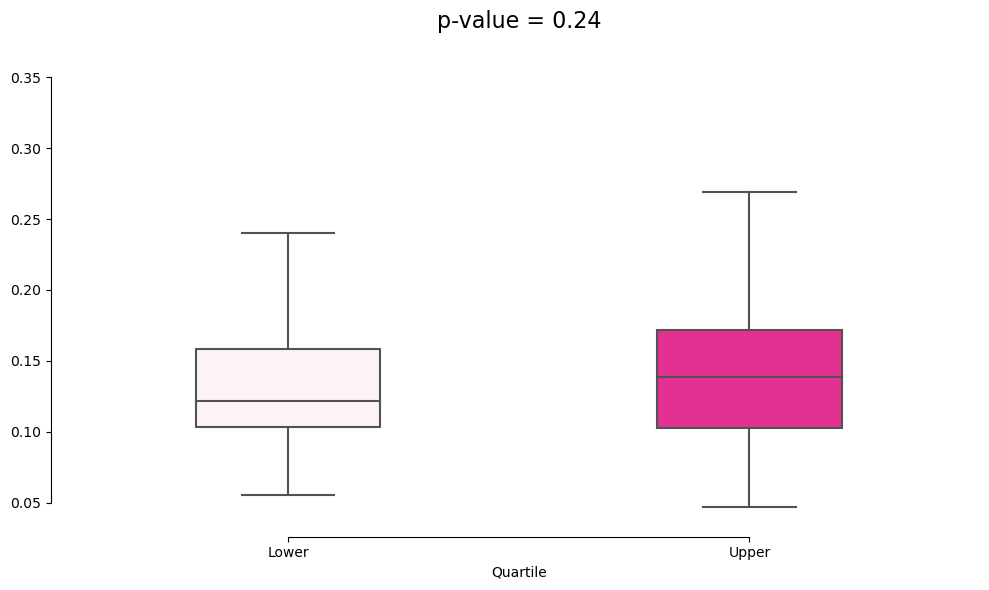

In [3]:
#mappability is not different between modes
import os
os.chdir('/scratch/ak8725/chess/whole_lifted/500kb_250kb_all_regions/NPB-Oruf/')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from files into DataFrames
right_data = pd.read_csv('ms_right.txt', sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])
left_data = pd.read_csv('ms_left.txt', sep='\t', header=None, names=['chr', 'start', 'end', 'col4'])

# Create a combined DataFrame for both groups
combined_data = pd.concat([left_data, right_data], keys=['Lower', 'Upper'])

# Create transparent box plots with customized colors
plt.figure(figsize=(10, 6))

# Define custom colors for the box plots and points
boxplot_colors = ['lavenderblush', 'deeppink']
point_colors = 'black'

# Create box plots with custom colors
b = sns.boxplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', width=0.4, fliersize=0,
            palette=boxplot_colors)

# Customize the plot
# plt.title('')
plt.xlabel('Quartile')
plt.ylabel('')

# Overlay individual data points as black scatter plots
# sns.stripplot(data=combined_data, x=combined_data.index.get_level_values(0), y='col4', jitter=True,
#               color=point_colors, alpha=0.5, size=5)

sns.despine(offset = 5, trim = True)
b.set_title("p-value = 0.24", fontsize = 16)

# Manually add labels to box plots
ax = plt.gca()

plt.tight_layout()
plt.savefig('ms.png', dpi=300, bbox_inches='tight')
plt.show()